*Goal*: find out if the dataset fits the data requirements

*Data Requirements*:
* user is present in all intervals
* user activity is >80% of all time intervals
* month 1, user has >5 rates
* month 0, to pre-train model
* items are comparable
* timestamp
* implicit feedback
* ranking problem


# update sys.path

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [2]:
import pandas as pd 
# from data_utils import get_namepaths_amazon_digimusic_isgd
from data_utils import getDF
from dataset_evaluation_utils import * # filter_out_users_with_less_than_k_rates, split_timestamp, sample_time_period, get_interactions_info

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

___
# Amazon Digital Music
Small subset, ratings only.  


Ratings only: These datasets include no metadata or reviews, but only (item,user,rating,timestamp) tuples. 


https://nijianmo.github.io/amazon/index.html

## define variables

In [3]:
dataset_name = 'Amazon_Digital_Music'
user_col = 'user_id'
item_col = 'item_id'
rate_col = 'rating'
time_col = 'timestamp'

In [4]:
orig_df = pd.read_csv("../datasets/Digital_Music.csv", 
                            names=[item_col, user_col, rate_col, time_col])

orig_df.head()

,item_id,user_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584082 entries, 0 to 1584081
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   item_id    1584082 non-null  object 
 1   user_id    1584082 non-null  object 
 2   rating     1584082 non-null  float64
 3   timestamp  1584082 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 48.3+ MB


In [6]:
orig_df[user_col] = orig_df[user_col].astype(str)#'category')
orig_df[item_col] = orig_df[item_col].astype(str)#'category')
#.apply(lambda x : str(x))

# how many interactions per time unit for a given user?

## remove duplicates? flag remove_duplicated_interactions

In [7]:
remove_duplicated_interactions = False
# duplicate entries -> how many times the user has seen the same item in the same day

In [8]:
# there is a lot of duplicate entries...
orig_df[[user_col, item_col, time_col]].value_counts()

user_id               item_id     timestamp 
A3DG93E8TXMKZF        B001KOWH0G  1397520000    51
A23OB9FM3MUYXT        B00137ILRS  1332979200    18
                      B00137MMAU  1332115200    10
AWG2O9C42XW5G         9434682614  1396396800    10
A23OB9FM3MUYXT        B000VWMT7Y  1333324800    10
                                                ..
A3HWICCEA97SZ6        B00Y41VJ4M  1442534400     1
A3HWIG1CF0EYBA        B00NAPZIIG  1431734400     1
A3HWIHF2G2TQRH        B000VZIO0W  1421884800     1
                      B014EPXN64  1463702400     1
A00041408PB8URN3FSQ6  B003YPD15E  1436140800     1
Length: 1518306, dtype: int64

In [9]:
orig_df.loc[(orig_df[user_col]=='A3DG93E8TXMKZF') &
        (orig_df[item_col]=='B001KOWH0G') &
          (orig_df[time_col]==1397520000), rate_col].value_counts()

1.0    51
Name: rating, dtype: int64

In [10]:
orig_df.duplicated().any()

True

In [11]:
if remove_duplicated_interactions:
    data_clean = orig_df[~orig_df.duplicated()]
    print('is there duplicated interactions user A, item alpha, rate x, time z? ',data_clean.duplicated().any())
    print('percentage of rows kept: ', data_clean.shape[0]/orig_df.shape[0])
else:
    data_clean = orig_df.copy()
    print('is there duplicated interactions user A, item alpha, rate x, time z? ', data_clean.duplicated().any())
    print('duplicate entries NOT deleted')

is there duplicated interactions user A, item alpha, rate x, time z?  True
duplicate entries NOT deleted


## split_timestamp

In [12]:
data_clean = split_timestamp(data_clean)
data_clean.head()

,item_id,user_id,rating,timestamp,date,year-month,year,month,day
2092,9714721180,A2SY49Z6H96QVR,5.0,877305600,1997-10-20,1997-10-01,1997,10,20
83632,B0013D89TW,A2XT7XLQ8DD4NZ,5.0,880675200,1997-11-28,1997-11-01,1997,11,28
147526,B0013D89TW,A2XT7XLQ8DD4NZ,5.0,880675200,1997-11-28,1997-11-01,1997,11,28
117999,B00122Z4Y2,A3OS0Q4XX0QSA4,5.0,893203200,1998-04-22,1998-04-01,1998,4,22
54105,B00122Z4Y2,A3OS0Q4XX0QSA4,5.0,893203200,1998-04-22,1998-04-01,1998,4,22


# stats

In [13]:
d = data_clean[[user_col, item_col, 'rating', 'year-month', 'date']]
d.head()

,user_id,item_id,rating,year-month,date
2092,A2SY49Z6H96QVR,9714721180,5.0,1997-10-01,1997-10-20
83632,A2XT7XLQ8DD4NZ,B0013D89TW,5.0,1997-11-01,1997-11-28
147526,A2XT7XLQ8DD4NZ,B0013D89TW,5.0,1997-11-01,1997-11-28
117999,A3OS0Q4XX0QSA4,B00122Z4Y2,5.0,1998-04-01,1998-04-22
54105,A3OS0Q4XX0QSA4,B00122Z4Y2,5.0,1998-04-01,1998-04-22


# how many different users per month?

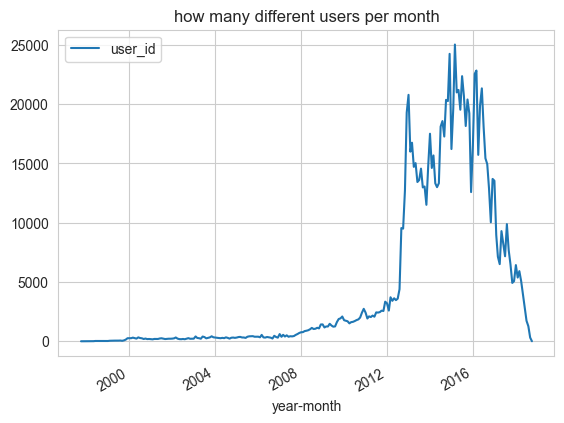

In [14]:
d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count().plot(title='how many different users per month');

# how many interactions per month

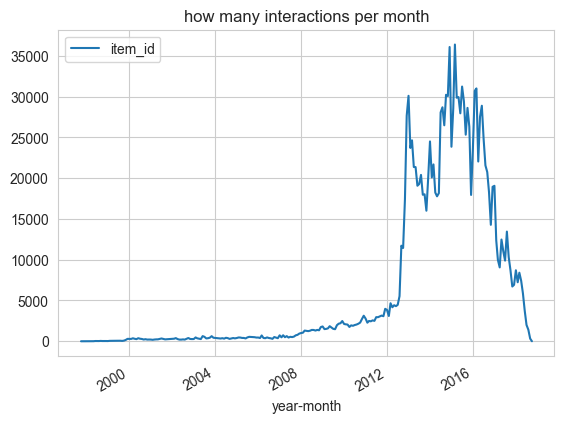

In [15]:
d[[item_col, 'year-month']]\
        .groupby('year-month')\
            .count().plot(title='how many interactions per month');

# how many months have more than 10k users?

In [16]:
(d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count() >= 10000).value_counts()

user_id
False      198
True        51
dtype: int64

# how many months in a year have more than 10k users?

In [17]:
_ = d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count().reset_index()
_.columns = ['year-month', 'users_count']


ym_list = _.loc[ _['users_count']>= 10000, 'year-month'].to_list() 

data_clean.loc[data_clean['year-month'].isin(ym_list),['year', 'year-month']].drop_duplicates().groupby('year').count()


,year-month
year,
2012,2
2013,12
2014,12
2015,12
2016,12
2017,1


years 2013 till 2017 are good to use

# how many interactions in 2012 Dec

(                user_id     item_id  rating year-month       date
 847109   A14XY6XHL3EXRB  B001CMNGJ2     5.0 2012-12-01 2012-12-01
 62334    A1DAKAKS4R02IM  B00136JGZU     5.0 2012-12-01 2012-12-01
 280967   A1C7FT12YICN0J  B007MU87KG     5.0 2012-12-01 2012-12-01
 803196   A2FXW2MEP7TBUI  B0013G1WQG     5.0 2012-12-01 2012-12-01
 1172335   ACV0IFO84L9TJ  B00A9OJWH4     3.0 2012-12-01 2012-12-01
 ...                 ...         ...     ...        ...        ...
 284404   A1HH27E0J7AZGA  B007ZMC3UG     5.0 2013-01-01 2013-01-31
 268072   A37HUQ6I3QNZDW  B006CLTGFQ     5.0 2013-01-01 2013-01-31
 967430    A4WZ5Q9RLJYL0  B003I3MSY2     5.0 2013-01-01 2013-01-31
 1110853  A2AIMXT9PLAM12  B0077GQ6BC     4.0 2013-01-01 2013-01-31
 823635   A3H8GFL4IOR5JR  B0018AKBPA     5.0 2013-01-01 2013-01-31
 
 [57748 rows x 5 columns],
 [('2012-12', '%Y-%m'), ('2013-02', '%Y-%m')],
 '2012-12',
 '2013-02')

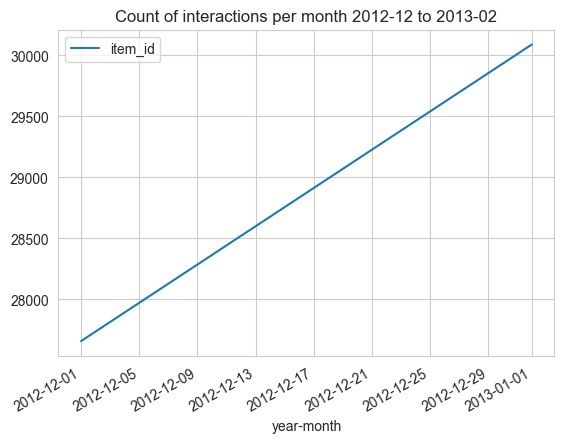

In [18]:
sample_time_period(['2012-12','2013-02'], d, col=item_col)

2013 Dec can be month 0 to pre-train the model

# how many users have full year activity between 2013 and 2016?

In [28]:
_ = data_clean[[user_col, 'year-month', 'year']]\
    .drop_duplicates()\
        .groupby([user_col, 'year'])\
            .count().reset_index()
_.columns = [user_col, 'year', 'months_count']
_

,user_id,year,months_count
0,A00041408PB8URN3FSQ6,2015,1
1,A0009988MRFQ3TROTQPI,2013,1
2,A0009988MRFQ3TROTQPI,2014,1
3,A0015420M7GRKSKTW32Z,2013,1
4,A0025284EDB2S5Q3G9PD,2015,1
...,...,...,...
1008688,AZZYJS5C53MVH,2016,1
1008689,AZZYJS5C53MVH,2018,1
1008690,AZZYKX2KZ0Q82,2013,1
1008691,AZZZ8WQXF8334,2015,1


In [22]:
# list of users with almost full year activity
p = 0.8
user_list = _.loc[ _['months_count']>= round(12*p), user_col].to_list() 

data_clean.loc[data_clean[user_col].isin(user_list),['year', user_col]].drop_duplicates().groupby('year').count()

,user_id
year,
2000,4
2001,4
2002,4
2003,3
2004,7
2005,13
2006,17
2007,24
2008,27


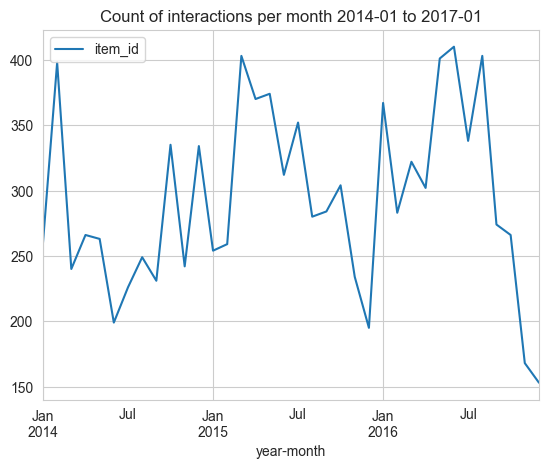

In [29]:
d_fyu_2014 = data_clean.loc[data_clean[user_col].isin(user_list)]
d_fyu_2014, _, _ ,_ = sample_time_period(['2014-01','2017-01'], d_fyu_2014, col=item_col)

In [36]:
print(d_fyu_2014[user_col].nunique())

_ = d_fyu_2014[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby([user_col])\
            .count().reset_index()
_.columns = [user_col, 'months_count']
_['three_years_percent'] = _['months_count']/(12*3)
_

128


,user_id,months_count,three_years_percent
0,A119Q9NFGVOEJZ,12,0.333333
1,A11YRHINAJNUQJ,17,0.472222
2,A14GK0E64J0WAS,35,0.972222
3,A14YTPQDH3PAZU,26,0.722222
4,A15JTJXQXO22JJ,24,0.666667
...,...,...,...
123,AVKHYC2D7MD56,21,0.583333
124,AVV5JGLBZERCM,25,0.694444
125,AXBCHD4VWC1BS,7,0.194444
126,AXFNC11IE5NYW,20,0.555556


# how many users have more than k-interactions per month?

In [ ]:
(d[[user_col, 'year-month']]\
        .value_counts() > 5).value_counts()

# get k-core/month users

In [ ]:
k = 4
user_interactions_per_month = d[[user_col, 'year-month']]\
                                        .value_counts().to_frame('interactions_per_month').reset_index()
users_kcore_month_list = user_interactions_per_month.loc[user_interactions_per_month['interactions_per_month']>k, user_col].to_list()
users_kcore_month_list[:10]

# k-core/month-users' interactions per month

In [ ]:
dc_kcore_filter = data_clean[user_col].isin(users_kcore_month_list)
data_clean.loc[dc_kcore_filter,[user_col, 'year-month']]\
                .groupby('year-month')\
                    .count().plot(title='how many *interactions per month* of '+str(k)+'-core/month-users');

if we bin it per trimestre, each bucket will have more interactions

# how many k-core-users per month?

In [ ]:
data_clean.loc[dc_kcore_filter, [user_col, 'year-month']]\
            .drop_duplicates()\
                .groupby('year-month')\
                    .count().plot(title='how many k-core-users per month?');

# how many months in a year have more than 790 k-core/month-users?

In [ ]:
_ = data_clean.loc[dc_kcore_filter, [user_col, 'year-month']]\
            .drop_duplicates()\
                .groupby('year-month')\
                    .count().reset_index()
_.columns = ['year-month', 'users_count']


ym_list = _.loc[ _['users_count']>= 790, 'year-month'].to_list() 

data_clean.loc[dc_kcore_filter &\
               data_clean['year-month'].isin(ym_list), ['year', 'year-month']]\
        .drop_duplicates() \
            .groupby('year').count()

# filter data with time period and k-core/month users

In [ ]:
time_period = [('2013-01', '%Y-%m'), ('2017-01', '%Y-%m')]
data = data_clean[(data_clean['year-month'] >= datetime.strptime(*time_period[0])) & \
                  (data_clean['year-month'] < datetime.strptime(*time_period[1])) &\
                    (data_clean[user_col].isin(users_kcore_month_list))]
data

In [ ]:
print('STAGE -> What is the user presence distribution based on month, quarter, and semester?')
n_days_sample = (datetime.strptime(*time_period[1]) - datetime.strptime(*time_period[0])).days
print('number of days in the time period sampled: ',n_days_sample)

if n_days_sample >= 182:
    user_presence_df, user_month_interactions,\
        trimestres, user_trimestre_interactions,\
        semestres, user_semestre_interactions = get_interactions_info(data=data, 
                                                                        user_col=user_col,
                                                                        quarter_info=True, 
                                                                        semester_info=True)
elif n_days_sample >= 91:
    user_presence_df, user_month_interactions,\
        trimestres, user_trimestre_interactions = get_interactions_info(data=data, 
                                                                        user_col=user_col,
                                                                        quarter_info=True, 
                                                                        semester_info=False)
else:
    user_presence_df, user_month_interactions = get_interactions_info(data=data, 
                                                                        user_col=user_col,
                                                                        quarter_info=False, 
                                                                        semester_info=False)

plot_user_presence_distribution(user_presence_df, dataset_name)          

# user_presence_df.to_csv('output/amazon_digmusic_dump/sample_'+sample_str+'_user_presence_df.csv', index=False)
# user_month_interactions.to_csv('output/amazon_digmusic_dump/sample_'+sample_str+'_user_month_interactions.csv', index=False)


In [ ]:
if n_days_sample >= 91:
    plot_interactions_per_qns(user_interactions=user_trimestre_interactions, 
                            date_range=trimestres, 
                            dataset_name=dataset_name, 
                            type_of_range='quarter')
    # joblib.dump(trimestres, 'output/amazon_digmusic_dump/sample_'+sample_str+'_trimestres.joblib')

if n_days_sample >= 182:
    plot_interactions_per_qns(user_interactions=user_semestre_interactions, 
                            date_range=semestres,
                            dataset_name=dataset_name,
                            type_of_range='semester')
    # joblib.dump(semestres, 'output/amazon_digmusic_dump/sample_'+sample_str+'_semestres.joblib')

In [ ]:
user_presence_df.head()

In [ ]:
user_month_interactions.head()

In [ ]:
user_trimestre_interactions.head()

In [ ]:
user_semestre_interactions.head()

In [ ]:
import joblib
sample_str = str(time_period[0][0])+'_until_'+str(time_period[1][0])
user_presence_df.to_csv('output/amazon_digmusic_dump/sample_'+sample_str+'_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazon_digmusic_dump/sample_'+sample_str+'_user_month_interactions.csv', index=False)
joblib.dump(trimestres, 'output/amazon_digmusic_dump/sample_'+sample_str+'_trimestres.joblib')
joblib.dump(semestres, 'output/amazon_digmusic_dump/sample_'+sample_str+'_semestres.joblib')

# get k-core-users/trimestre

In [ ]:
def create_period_column(df, period_col_name, period_timestamps):
    df.loc[:, period_col_name] = 0

    for i, (t_start, t_end) in enumerate(period_timestamps):
        t_filter = (df['year-month'] >= t_start) & \
                    (df['year-month'] < t_end)
        df.loc[t_filter, period_col_name] = i
    return df

def get_k_core_per_period(df, period, period_timestamps=None, k=5, m=1000, user_col='user_id'):
    '''
        df: pd.DataFrame , must have a user_col, 'year' and 'year-month' columns
                        will add period column to frame
        period: str , ['month', 'trimestre', 'semestre']
        period_timestamps: list , list of timestamp
        k: int , minimum number of interactions per period
        m: int , minimum number of k-core-users per period
        user_col: str = 'user_id'
    '''

    if period == 'month':
        period_col_name = 'year-month'

    elif period == 'trimestre':
        period_col_name = 'trimestre_n'
        df = create_period_column(df, period_col_name, period_timestamps)
        
    elif period == 'semestre':
        period_col_name = 'semestre_n'
        df = create_period_column(df, period_col_name, period_timestamps)

    # get user interactions per period
    interactions_col_name = 'interactions_per_'+period

    user_interactions_per_period = data[[user_col, period_col_name]]\
                                            .value_counts().to_frame(interactions_col_name).reset_index()
    users_kcore_period_list = user_interactions_per_period.loc[user_interactions_per_period[interactions_col_name]>=k, user_col].to_list()

    # filter users
    kcore_filter = data[user_col].isin(users_kcore_period_list)
    
    # plot 'how many *interactions per period* of k-core/period-users'
    df.loc[kcore_filter,[user_col, period_col_name]]\
                    .groupby(period_col_name)\
                        .count().plot(title='how many *interactions per '+period+'* of '+str(k)+'-core/'+period+'-users');


    # plot 'how many k-core-users per period?'
    df.loc[kcore_filter,[user_col, period_col_name]]\
        .drop_duplicates()\
            .groupby(period_col_name)\
                .count().plot(title='how many *'+str(k)+'-core/'+period+'-users* per '+period+'?');


    print('Number of periods that have at least '+str(m)+' '+str(k)+'-core/'+period+'-users in each year')
    _ = df.loc[kcore_filter,[user_col, period_col_name]]\
            .drop_duplicates()\
                .groupby(period_col_name)\
                    .count().reset_index()
    _.columns = [period_col_name, 'users_count']

    ym_list = _.loc[ _['users_count']>= m, period_col_name].to_list() 

    print(df.loc[kcore_filter &\
                 df[period_col_name].isin(ym_list), ['year', period_col_name]]\
            .drop_duplicates() \
                .groupby('year').count())
    
    return df, kcore_filter


In [ ]:
len(trimestres)

In [ ]:
data

In [ ]:
data, users_2kcore_month_filter = get_k_core_per_period(data,
                                                        period='month',
                                                        period_timestamps=None,
                                                        k=2,
                                                        m=1000)

In [ ]:
data, users_5kcore_trimestre_filter= get_k_core_per_period(data,
                                                            period='trimestre',
                                                            period_timestamps=trimestres,
                                                            k=5,
                                                            m=1000)

In [ ]:
p = 0.5 
n_days = (trimestres[0][1] - trimestres[0][0]).days

data = get_k_core_per_period(data,
                            period='trimestre',
                            period_timestamps=trimestres,
                            k= round(n_days*p), # min number of interactions = 0.5 of the n_days of time period
                            m=1000)

In [ ]:
data = get_k_core_per_period(data,
                            period='semestre',
                            period_timestamps=semestres,
                            k=5,
                            m=1000)

# users_5kcore_trimestre_filter

In [ ]:
data_5core_trimestre = data[users_5kcore_trimestre_filter]
data_5core_trimestre

In [ ]:
user_interactions_per_period = data[[user_col, period_col_name]]\
                                            .value_counts().to_frame(interactions_col_name).reset_index()
users_kcore_period_list = user_interactions_per_period.loc[user_interactions_per_period[interactions_col_name]>=k, user_col].to_list()

# filter users
kcore_filter = data[user_col].isin(users_kcore_period_list)

# plot 'how many *interactions per period* of k-core/period-users'
df.loc[kcore_filter,[user_col, period_col_name]]\
                .groupby(period_col_name)\
                    .count().plot(title='how many *interactions per '+period+'* of '+str(k)+'-core/'+period+'-users');


# plot 'how many k-core-users per period?'
df.loc[kcore_filter,[user_col, period_col_name]]\
    .drop_duplicates()\
        .groupby(period_col_name)\
            .count().plot(title='how many *'+str(k)+'-core/'+period+'-users* per '+period+'?');

In [ ]:
data_5core_trimestre[[user_col, item_col, 'trimestre_n']]\
    .drop_duplicates()\
    .groupby(['trimestre_n',user_col] )\
    .count()\
    # .mean()

# meta data

In [ ]:
meta_dm = getDF('../datasets/meta_Digital_Music.json.gz')
'''
where

asin - ID of the product, e.g. 0000031852
title - name of the product
feature - bullet-point format features of the product
description - description of the product
price - price in US dollars (at time of crawl)
imageURL - url of the product image
imageURL - url of the high resolution product image
related - related products (also bought, also viewed, bought together, buy after viewing)
salesRank - sales rank information
brand - brand name
categories - list of categories the product belongs to
tech1 - the first technical detail table of the product
tech2 - the second technical detail table of the product
similar - similar product table
'''

meta_dm.head()

In [ ]:
def get_filter_presence_in_column(df, col):
    return df.apply(lambda x: x[col]!=[], axis=1)

def get_presence_in_column(df, col):
    return get_filter_presence_in_column(df, col).value_counts()/df.shape[0]

In [ ]:
print('true -> there is a value\nfalse -> empty')
print('\n'+'category'+'\n', get_presence_in_column(meta_dm, 'category'))
print('\n'+'description'+'\n', get_presence_in_column(meta_dm, 'description'))
print('\n'+'feature'+'\n', get_presence_in_column(meta_dm, 'feature'))
print('\n'+'rank'+'\n', get_presence_in_column(meta_dm, 'rank'))
print('\n'+'brand'+'\n', get_presence_in_column(meta_dm, 'brand'))


we could use rank and brand

In [ ]:
meta_dm.loc[get_filter_presence_in_column(meta_dm, 'rank'), ['asin','brand', 'rank']]